In [0]:
# Companion codes for genMarkov: https://github.com/Aniq55/genMarkov/

In [0]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from numpy.random import random_sample
import seaborn as sns
import scipy
from scipy.integrate import quad
from scipy import stats


sns.set()
matplotlib.rcParams.update({'font.size': 15})
np.random.seed(42)

In [0]:
# source: https://github.com/Aniq55/genMarkov/blob/master/utils.py

def choose(choices, weights):
    bins = np.add.accumulate(weights)
    return choices[np.digitize(random_sample(1), bins)][0]

def getP(mu, sigma, N):
    """
    Returns the probablities (p_i) as defined in the section III, they are used
    to generate the transition probability matrix.
    The values mu and sigma are used for obtaining the pdf.
    """
    x = np.linspace(0, 1, 100)
    y = scipy.stats.norm.pdf(x, mu, sigma)

    def normal_distribution_function(x):
        """
        Returns a pdf of a normal distribution function with defined mu and
        sigma
        """
        value = scipy.stats.norm.pdf(x, mu, sigma)
        return value

    def integral(x1, x2):
        """
        Integrates `normal_distribution_function` (defined above) between x1
        and x2. This is used tp generate the probabilities.
        """
        res, _ = quad(normal_distribution_function, x1, x2)
        return res

    p =[]
    for i in range(N):
        p.append(integral(i / N, (i + 1) / N))

    p = np.array(p)
    p /= np.float64(p.sum())

    return p


In [0]:
# source: https://github.com/Aniq55/genMarkov/blob/master/chain.py

class PoissonProcess():

    def __init__(self, L, B, W):
        self.Lambda = L
        self.beta = B
        self.omega = W

    def time_variance(self, t):
        return self.Lambda + self.beta * np.sin(self.omega * t)

    def interval(self, t):
        return np.random.poisson(self.time_variance(t))


In [0]:
# source: https://github.com/Aniq55/genMarkov/blob/master/markov.py

class MarkovModel():
    """
    Produces a Markov model with mu, sigma and N states
    """

    def __init__(self, mu, sigma, N):
        self.prob= getP(mu, sigma, N)
        self.N_states= N
        self.current_state= 0
        self.states= np.array(list(range(self.N_states)))

    def transition(self):
        self.current_state = choose(self.states , self.prob)
        return self.current_state

    def draw(self):
        """
        Drawing from a uniform probability distribution in the range of
        x_i, i.e., r ∼ U(x_i). r denotes the reward.
        Note the definition of x_i here, x_i ∈[(i − 1) / N , i / N). However,
        we have used 0-based indexing in the code.
        """
        return np.random.uniform(
            self.current_state / self.N_states,
            (self.current_state + 1)/ self.N_states
        )

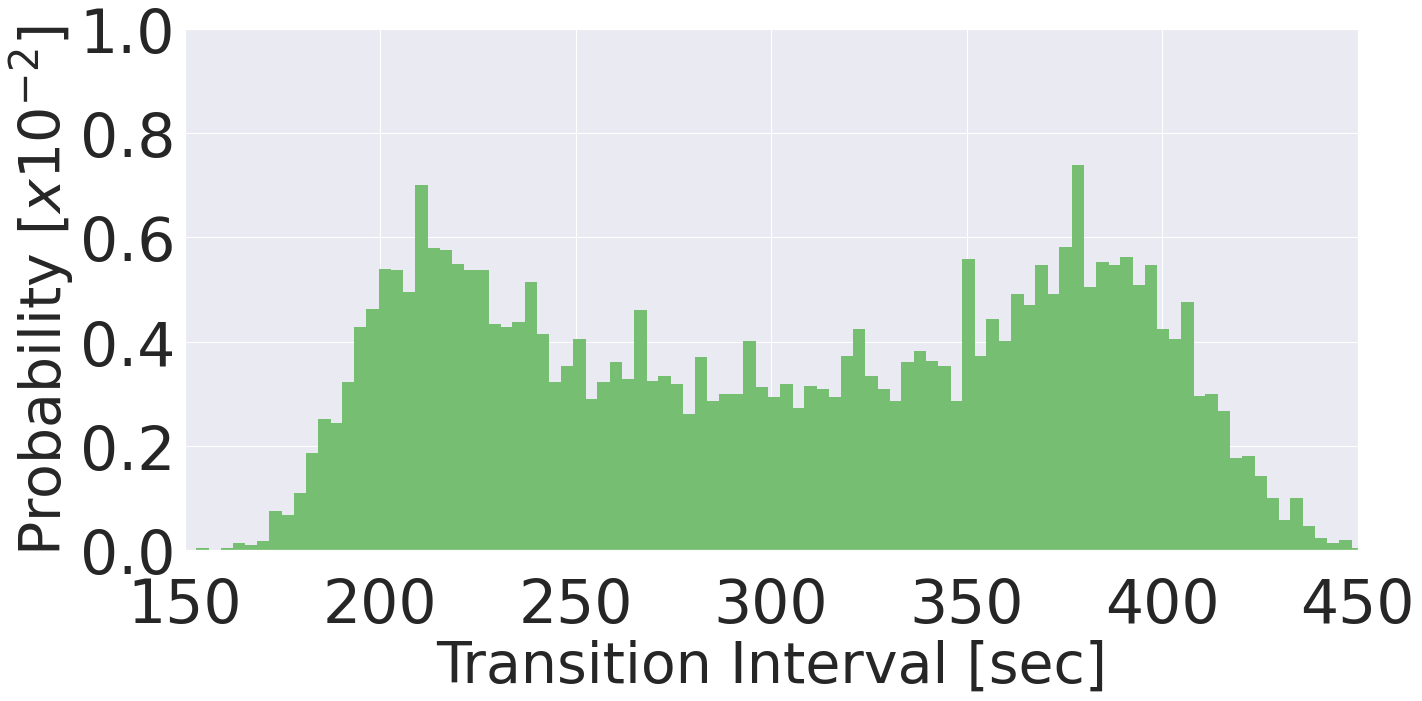

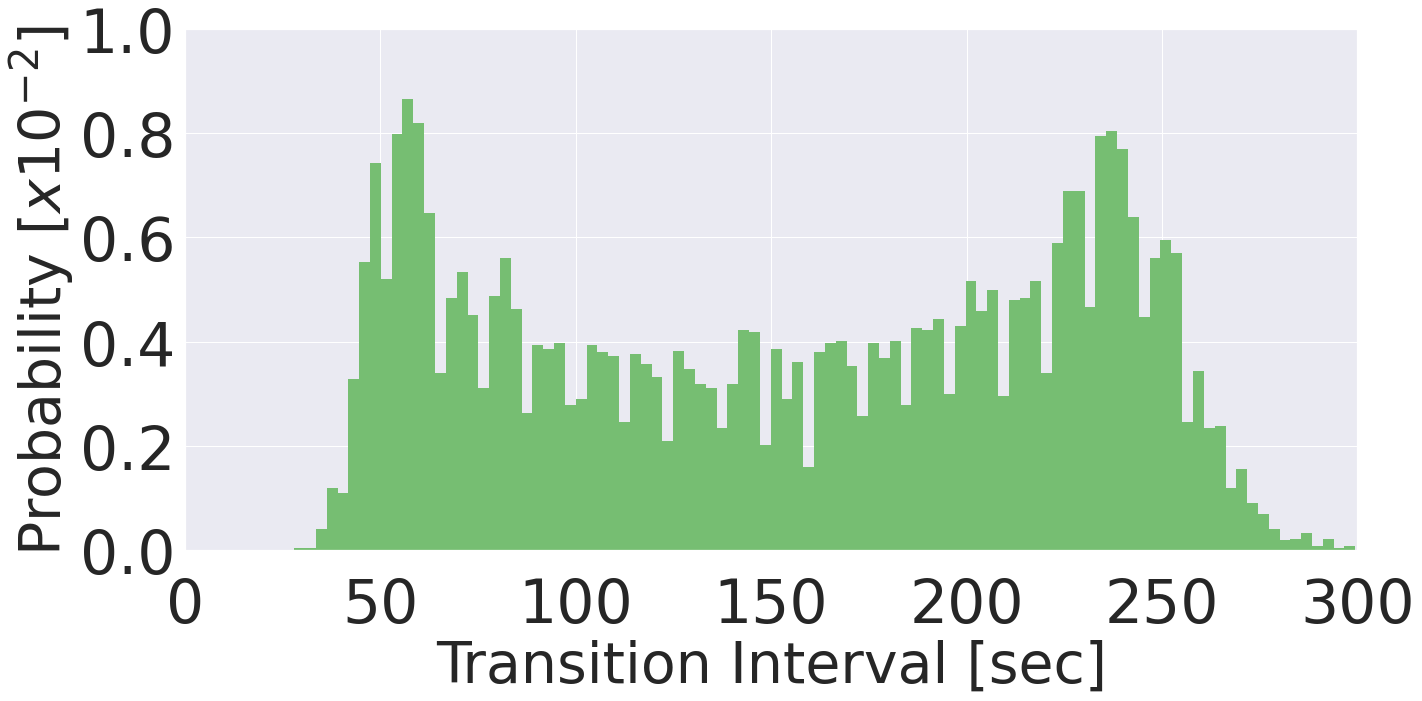

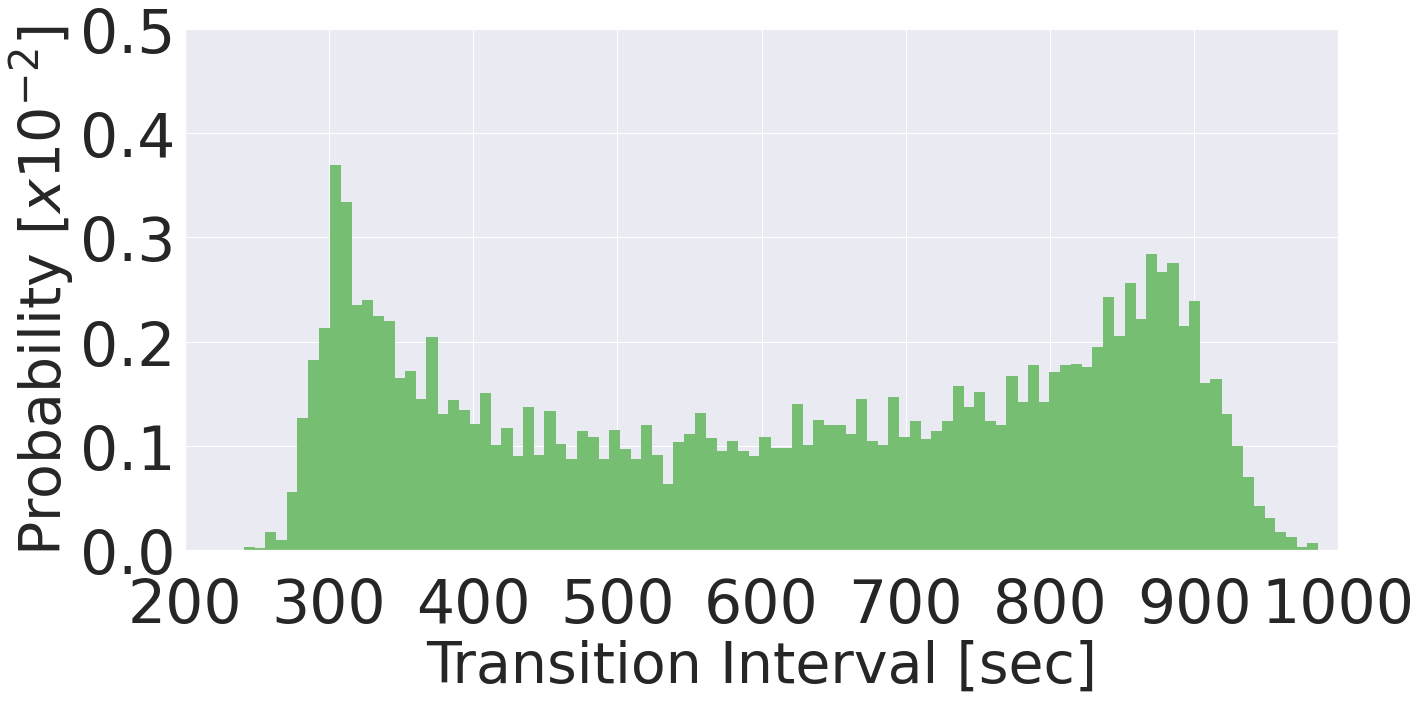

In [5]:
lambda0 = 300
omega0 = 2*np.pi/3600
poisson_processes = {
    1: PoissonProcess(lambda0, lambda0/3, 3*omega0),
    2: PoissonProcess(lambda0/2, lambda0/3, 2*omega0),
    3: PoissonProcess(lambda0*2, lambda0, omega0),
}

plt.rcParams["patch.force_edgecolor"] = False

all_graph = [1, 2, 3]

# graph settings
width = [None, 3.25, 2.8, 7.8]
ylim = [None, (0, 1), (0, 1), (0, 0.5)]
xlim = [None, (150, 450), (0, 300), (200, 1000)]

for which in all_graph:
    poison_process = poisson_processes[which]
    time = []
    ITERATIONS = 10000
    for i in range(ITERATIONS):
        time.append(poison_process.interval(i))

    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid(True)
    hist, bin_edges = np.histogram(time, density=True, bins=100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    hist = hist * 100
    plt.bar(
        bin_centers, hist, width=width[which], color="#76BE72", align="center",
        rasterized=True
    )
    plt.xlabel("Transition Interval [sec]", fontsize=57)
    plt.ylabel("Probability $[x10^{-2}]$", fontsize=57)
    plt.tick_params(axis="x", pad=20)
    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)
    plt.ylim(ylim[which])
    plt.xlim(xlim[which])
    plt.tight_layout()
    plt.savefig(f'T{which}.eps', format='eps', dpi=100)
    plt.show()


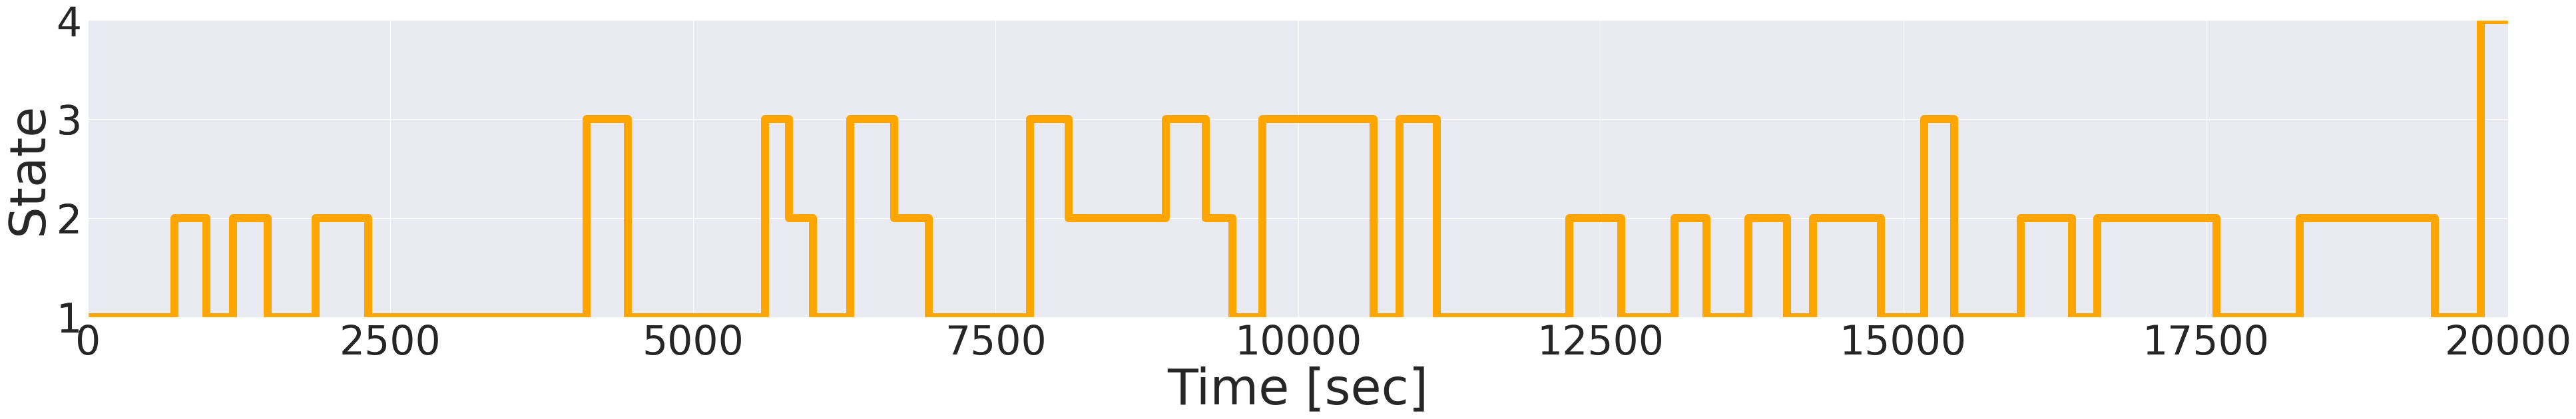

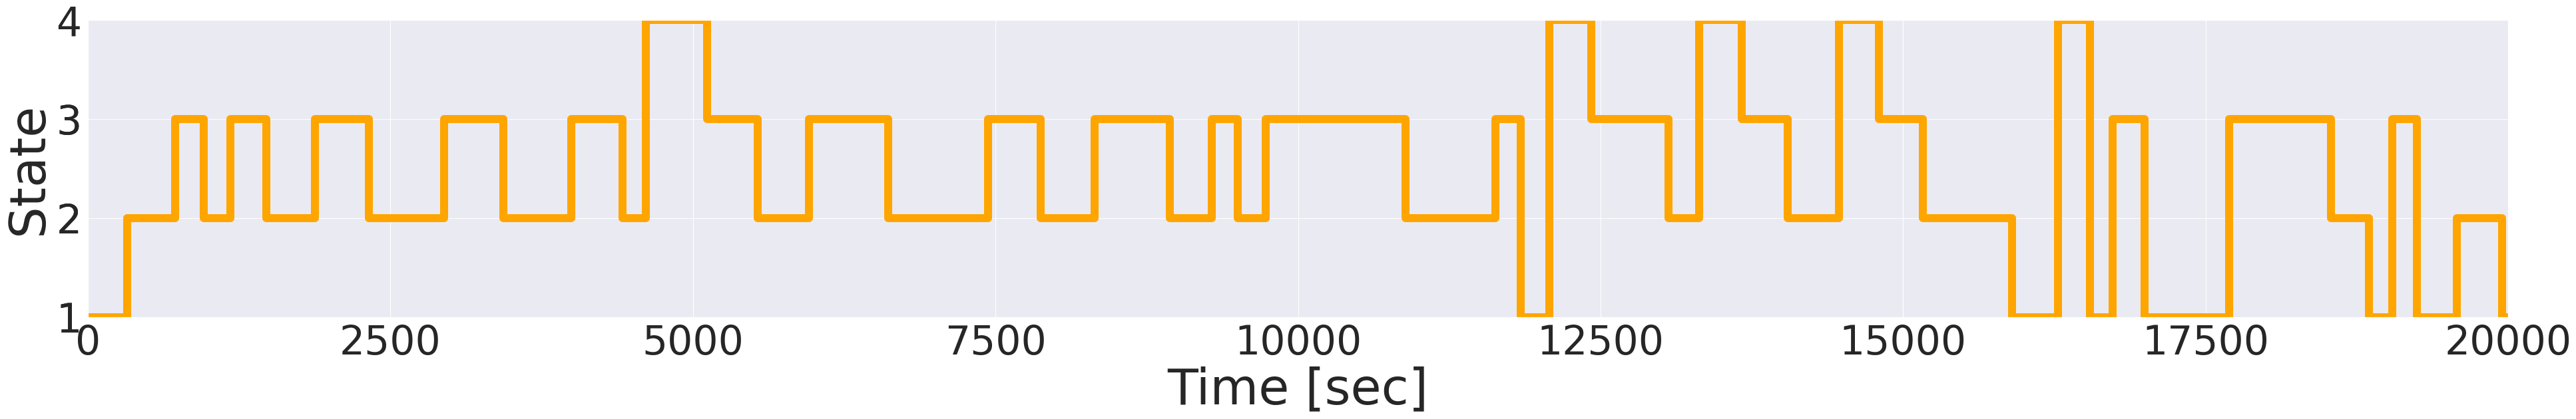

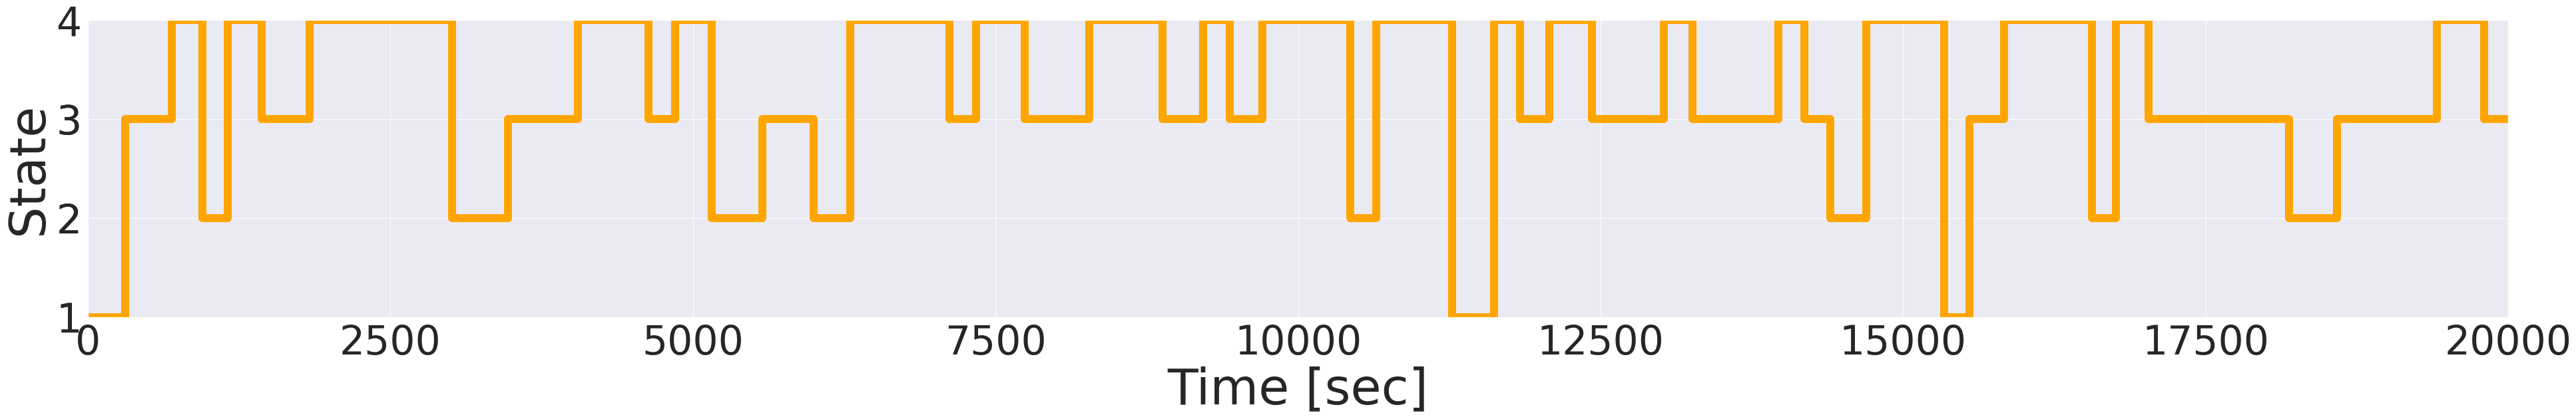

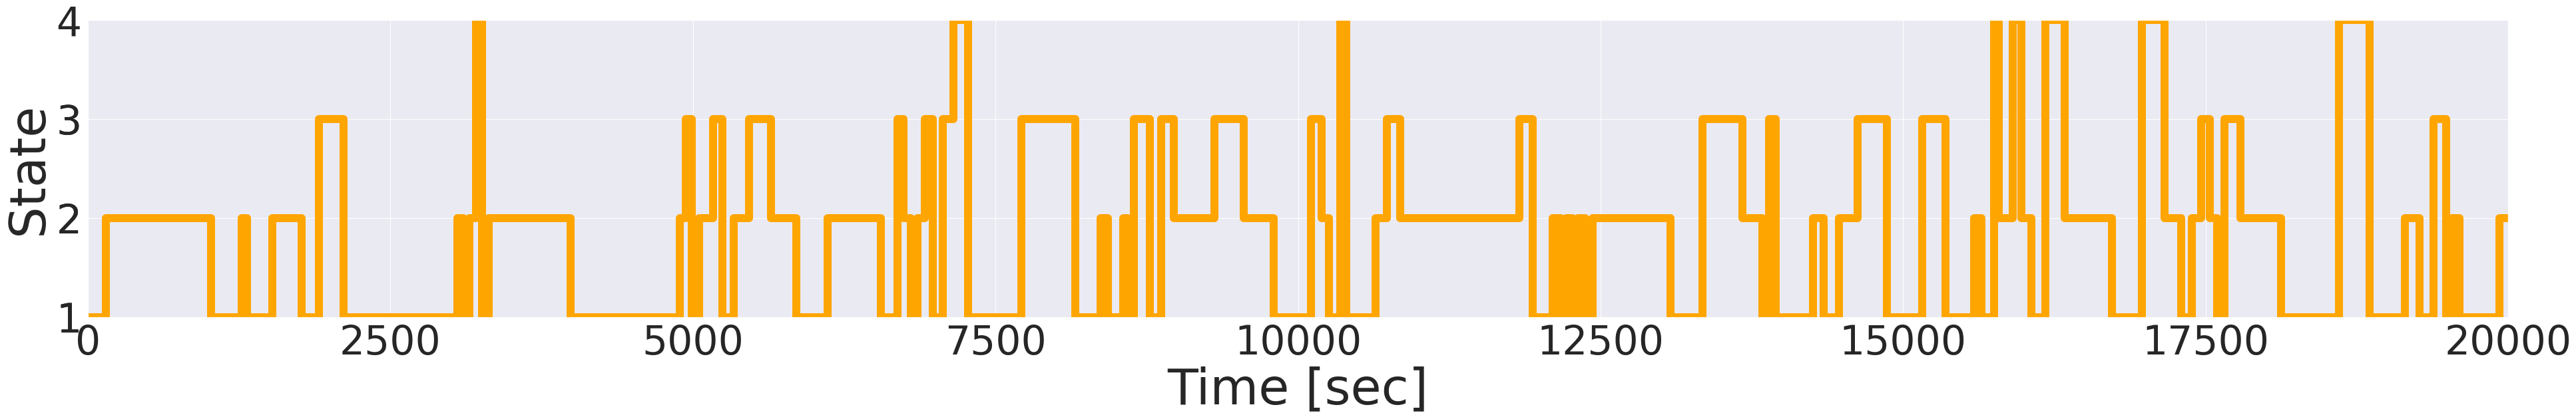

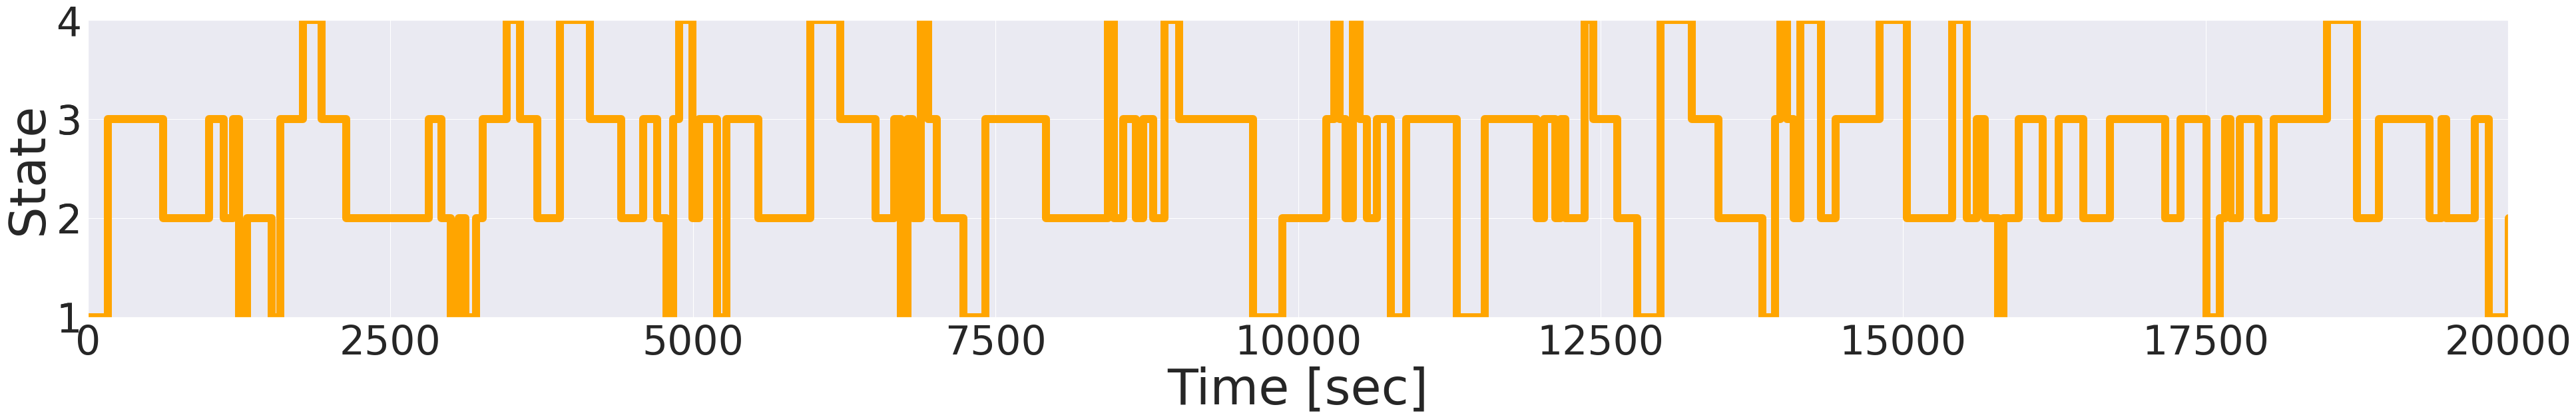

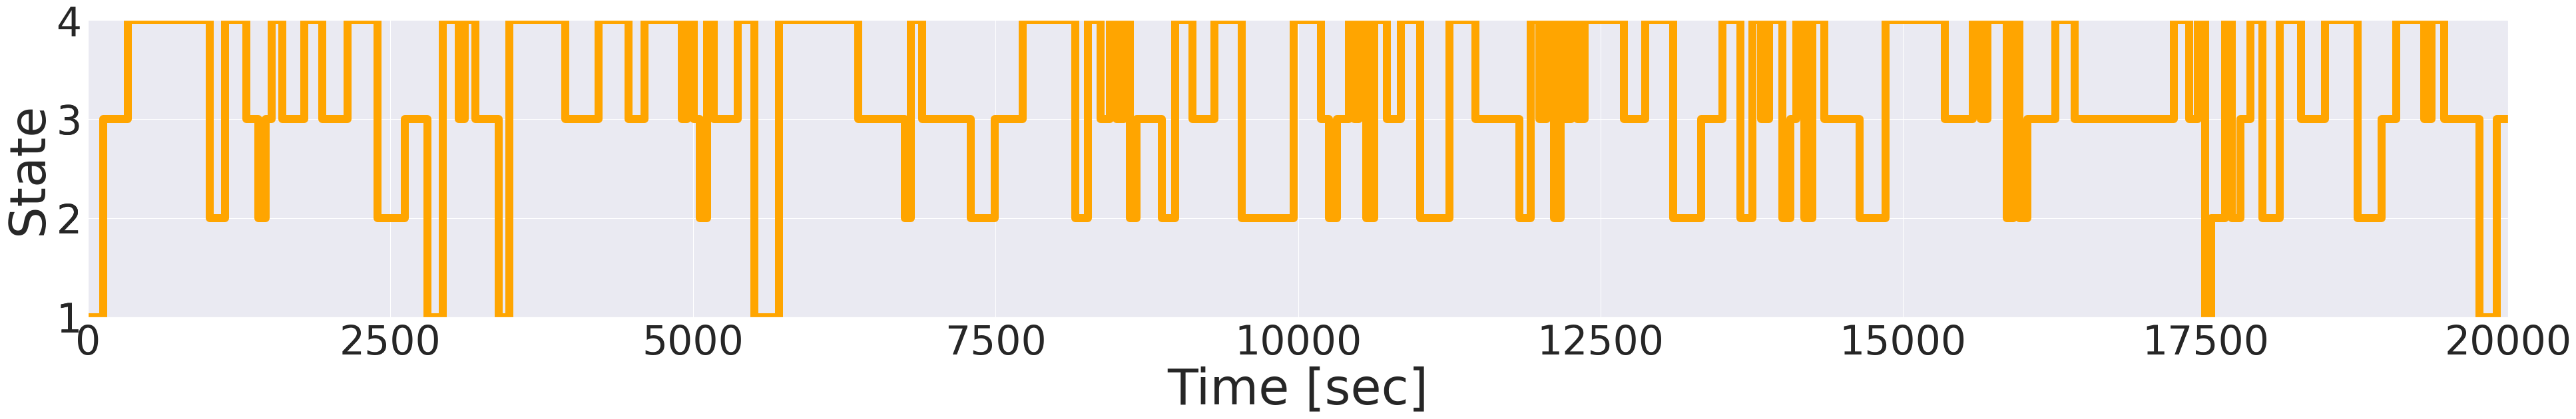

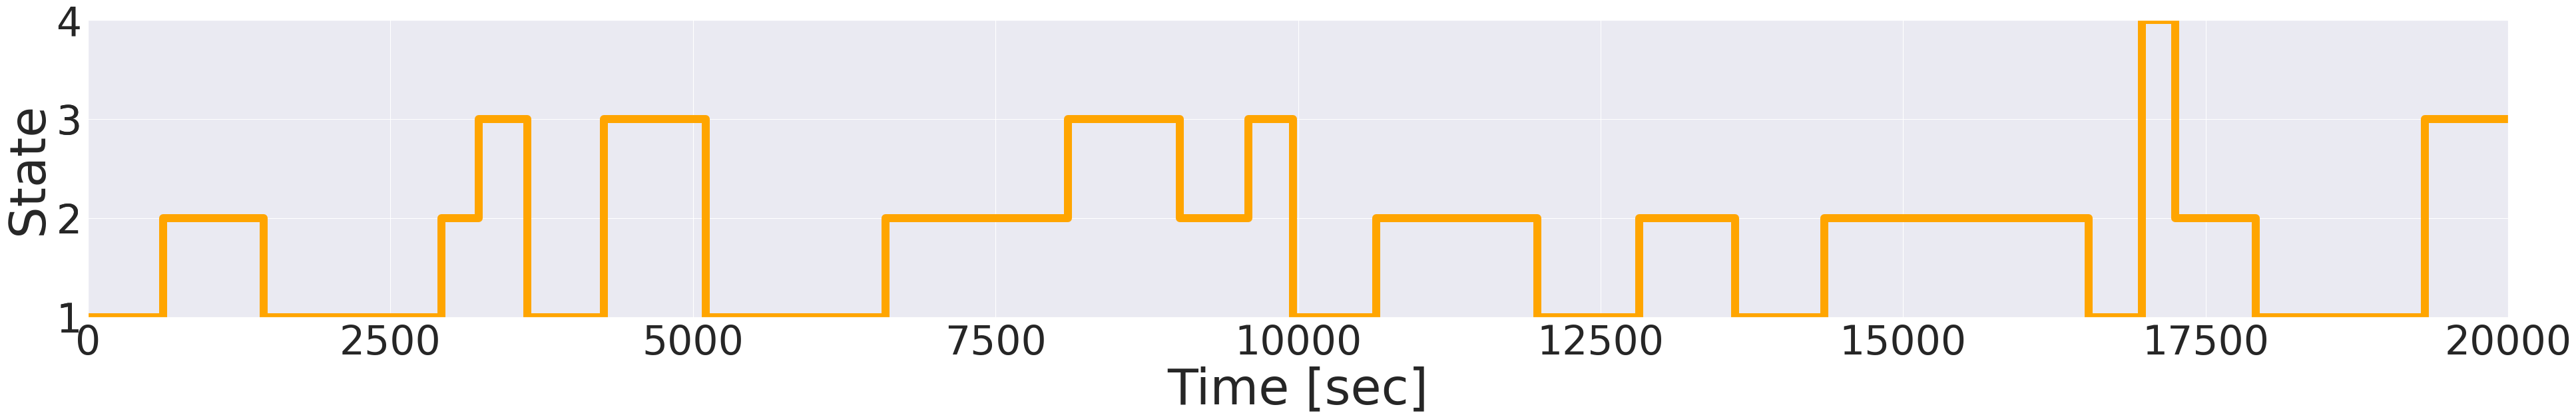

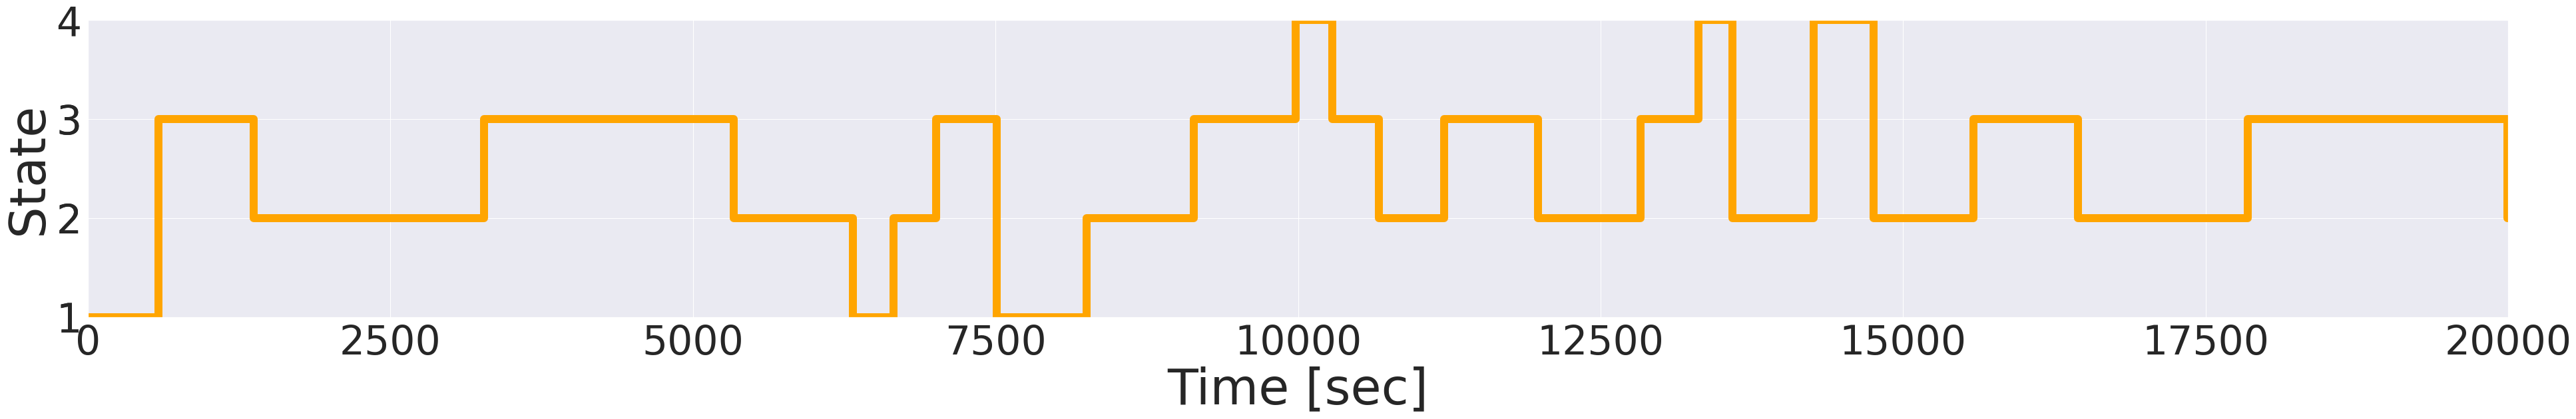

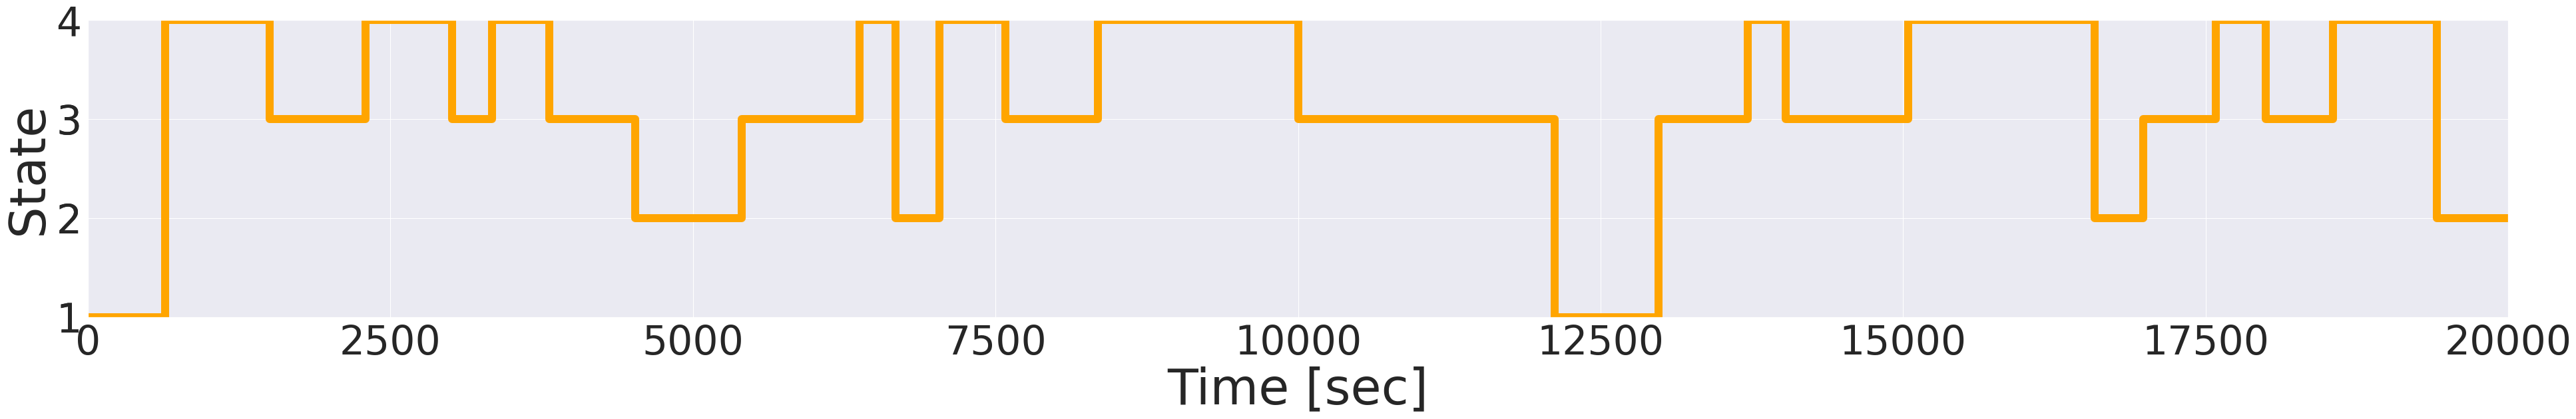

In [8]:
markov_models = {
    1: MarkovModel(0.2, 0.3, 4),
    2: MarkovModel(0.5, 0.2, 4),
    3: MarkovModel(0.8, 0.3, 4),
}

    
all_p = [1, 2, 3]
all_m = [1, 2, 3]
for which_p in all_p:
    for which_m in all_m:
        poisson_process = poisson_processes[which_p]
        markov_model = markov_models[which_m]

        CHAIN = {}
        CHAIN['STATE'] = []
        CHAIN['TIME'] = []

        CHAIN['STATE'].append(0)
        CHAIN['TIME'].append(0)

        ITERATIONS = 200
        for i in range(ITERATIONS):
            CHAIN['STATE'].append(markov_model.transition())
            CHAIN['TIME'].append(
                CHAIN['TIME'][-1] + poisson_process.interval(CHAIN['TIME'][-1])
            )
        
        for num in range(len(CHAIN["STATE"])):
            CHAIN["STATE"][num] += 1

        fig = plt.gcf()
        fig.set_size_inches(54, 9)
        plt.step(
            CHAIN['TIME'], CHAIN['STATE'], color="orange", where="post",
            linewidth=12
        )
        plt.ylim(1, 4)
        plt.xlim(0, 20000)
        plt.xlabel("Time [sec]", fontsize=75)
        plt.ylabel("State", fontsize=75)
        yint = []
        locs, labels = plt.yticks()
        for each in locs:
            yint.append(int(each))
        plt.xticks(fontsize=60)
        plt.yticks(yint, fontsize=60)
        plt.tight_layout()
        plt.savefig(
            f'state_v_timeM{which_m}-T{which_p}.eps', format='eps',
            dpi=1000
        )
        plt.show()


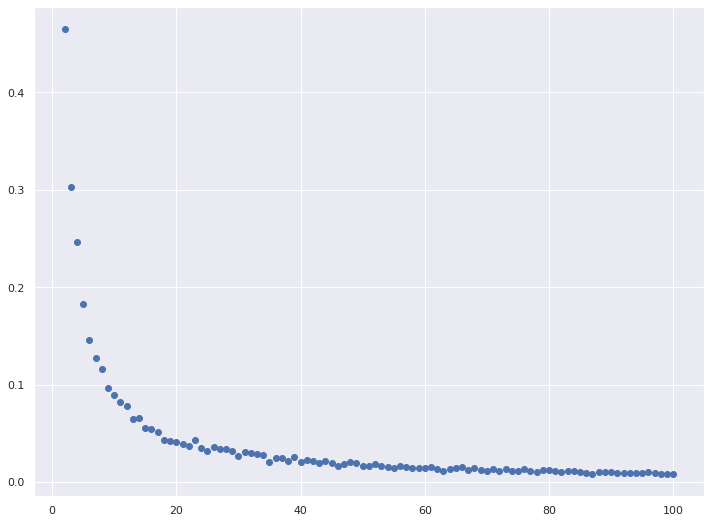

In [9]:
fig = plt.figure(figsize = (12, 9))
plt_s = []
ns = [i for i in range(2, 101)]
for which_m in all_m:
    mm = markov_models[which_m]
    cur = []
    for which in ns:
        CHAIN = {}
        CHAIN['STATE'] = []
        CHAIN['STATE'].append(0)

        ITERATIONS = 200
        for i in range(ITERATIONS):
            CHAIN['STATE'].append(mm.transition())
        
        hn = []
        for i in range(ITERATIONS-1):
            hn.append(abs(CHAIN["STATE"][i+1] - CHAIN["STATE"][i])/which)
            
        avg = sum(hn)/len(hn)
        cur.append(avg)
    plt_s.append(cur)

plt.scatter(ns, plt_s[0])
plt.show()

In [0]:
col = ["#797979", "#D65F5F", "#82C6E2"]
col1 = ["#DA8BC3", "#4C72B0", "#C44E52"]


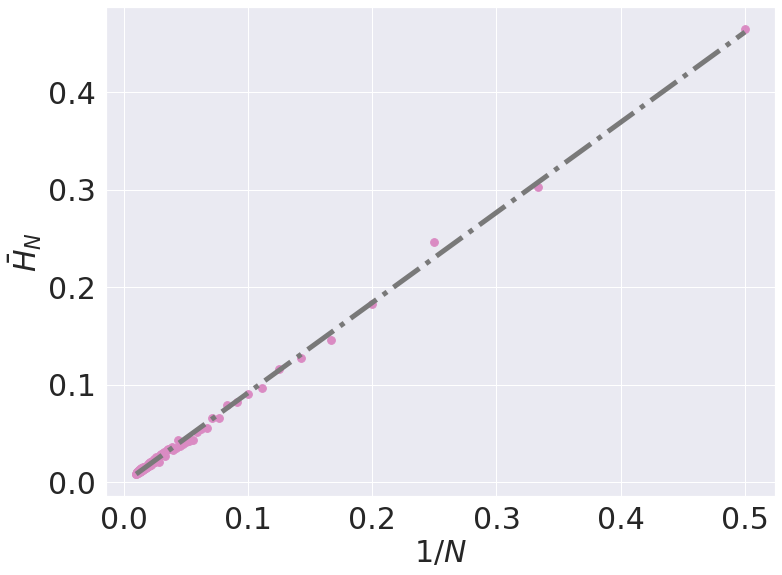

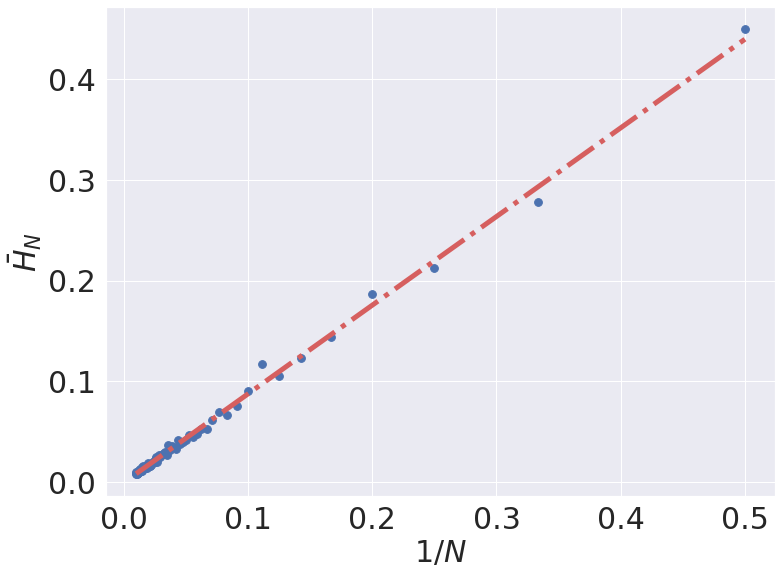

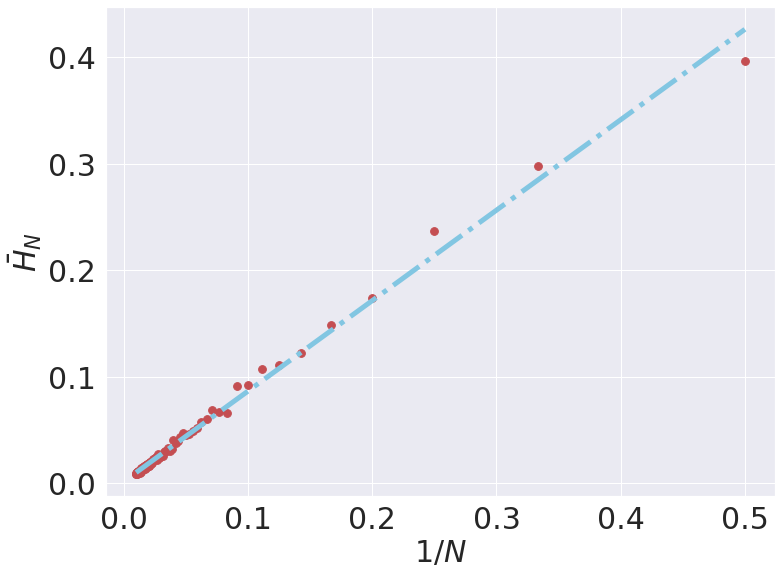

In [11]:
ns = np.array(ns)
for i in range(3):
    fig = plt.figure(figsize = (12, 9))
    plt.scatter(1 / ns, plt_s[i], color=col1[i], s=60)
    gradient, intercept, r_value, p_value, std_err = stats.linregress(
        1 / ns, plt_s[i]
    )
    mn = np.min(1 / ns)
    mx = np.max(1 / ns)
    x1 = np.linspace(mn, mx, 500)
    y1 = gradient * x1 + intercept
    plt.plot(x1,y1, ls="dashdot", color=col[i], linewidth=5)
    plt.xlabel("$1/N$", fontsize=30)
    plt.ylabel("$\\bar{H}_N$", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks([0.4, 0.3, 0.2, 0.1, 0.0],fontsize=30)
    plt.savefig(f'scatterM{i+1}.eps', format='eps', dpi=1000)
    plt.show()
